# Simple logistic model with uncertainty
We want
- Logistic regression 
- LASSO/Ridge regularization
- Uncertainty quantification and prior-ification

## Model
Let $Y_{it}$ be the Republican _score_, defined as the proportion of votes Republican received over the total votes received by Republican and Democratic candidates. Let $W_{it}$ be whether the Republican wins.

Assume that 
$$
Y_{it} \sim \mathcal{N}(X\beta, \sigma^2)
$$
We infer $\beta$ via a penalized logistic regression with cross-validation selection of the penalities. We infer $\sigma^2$ by simply taking the variance of the prediction errors.

On the test set, assume that polls are drawn from $\text{Bin}(n, Y) \approx \mathcal{N}(nY, nY(1-Y))$. This is a normal likelihood with normal prior Bayesian model, and the posterior is easy to compute.

In [199]:
import us
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm

In [200]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
sns.set_style('white')
plt.rcParams['figure.dpi'] = 150

In [201]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [202]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, ElasticNetCV

In [203]:
df = feather.read_dataframe('data/final_merged.feather').drop_duplicates()
df['raceyear'] = df['year']

In [214]:
trends = pd.read_csv('data/google_trends_3.csv').iloc[:,2:].drop_duplicates().rename(columns={'year' : 'raceyear'})

In [221]:
rec_trends = pd.read_csv('data/google_trends_2018.csv').iloc[:,1:8]

In [222]:
rec_trends = rec_trends.drop_duplicates().rename(columns={'year': 'raceyear'})
rec_trends

,district,state_fips,raceyear,rep_cand_oct,rep_cand_nov,dem_cand_oct,dem_cand_nov
0,3.0,1.0,2018.0,10.6875,23.2500,15.3125,22.3750
1,51.0,6.0,2018.0,9.0000,14.3125,13.4375,26.0000
2,4.0,39.0,2018.0,34.7500,60.5000,19.9375,27.6875
3,11.0,37.0,2018.0,28.4375,36.8750,17.2500,24.0000
4,3.0,39.0,2018.0,9.8125,9.5000,16.8750,16.0000
5,1.0,29.0,2018.0,0.0000,18.2500,6.0625,12.4375
6,24.0,36.0,2018.0,26.4375,33.2500,36.6875,46.6875
7,9.0,34.0,2018.0,20.7500,31.8750,26.2500,26.8125
8,11.0,17.0,2018.0,10.9375,18.3750,31.6250,33.6875
9,1.0,40.0,2018.0,6.3750,16.8750,11.0000,27.0625


In [216]:
trends = trends[trends.raceyear != 2018]

In [224]:
trends = pd.concat([trends, rec_trends])

In [225]:
trends = (trends.groupby(['raceyear', 'district', 'state_fips']).mean()
          .reset_index()
          .assign(
              rep_to_tot_nov=lambda x : x['rep_cand_nov'] / (x['dem_cand_nov'] + x['rep_cand_nov']),
              rep_to_tot_oct=lambda x : x['rep_cand_oct'] / (x['dem_cand_oct'] + x['rep_cand_oct']),
          ))

In [226]:
trends

,raceyear,district,state_fips,rep_cand_oct,rep_cand_nov,dem_cand_oct,dem_cand_nov,rep_to_tot_nov,rep_to_tot_oct
0,2010.0,0.0,2.0,11.437500,19.9375,4.687500,6.6875,0.748826,0.709302
1,2010.0,0.0,10.0,13.250000,3.5625,0.000000,20.3125,0.149215,1.000000
2,2010.0,0.0,30.0,0.000000,13.8125,11.000000,5.0000,0.734219,0.000000
3,2010.0,0.0,38.0,28.562500,30.1875,25.375000,18.9375,0.614504,0.529548
4,2010.0,0.0,46.0,30.187500,28.5625,0.000000,0.0000,1.000000,1.000000
5,2010.0,0.0,50.0,0.000000,0.0000,11.375000,20.5000,0.000000,0.000000
6,2010.0,0.0,56.0,11.750000,22.3750,0.000000,0.0000,1.000000,1.000000
7,2010.0,1.0,4.0,13.250000,23.9375,18.562500,15.6875,0.604101,0.416503
8,2010.0,1.0,5.0,13.687500,3.3750,5.875000,10.2500,0.247706,0.699681
9,2010.0,1.0,6.0,4.375000,6.9375,31.437500,55.8125,0.110558,0.122164


In [227]:
df = (df.merge(trends[['raceyear', 'district', 'state_fips', 'rep_cand_nov', 
                       'dem_cand_nov','rep_to_tot_nov', 'rep_to_tot_oct']], how='left',))

In [228]:
cols = ['rep_incumbent', 'dem_incumbent', 'dem_is_female', 'rep_is_female',
       'dem_percent', 'minority_percentage', 'pres_approval', 'same_as_pres_party_rep',
       'same_as_pres_party_dem', 'log_med_income', 'percent_bachelor_or_above',
        'rep_to_tot_oct', 'rep_to_tot_nov']
#        'rep_cand_oct', #'rep_cand_nov', 
#         'dem_cand_oct', #'dem_cand_nov', 'rep_to_tot_nov', 
#         'rep_to_tot_oct']

for year in df['raceyear'].unique():
    df.loc[df['raceyear'] == year, cols] = (df.loc[df['raceyear'] == year, cols]
                                        .fillna(df.loc[df['raceyear'] == year, cols]
                                                .mean()))

In [229]:
df = df.merge(past, how='left')

In [230]:
state = pd.get_dummies(df['state']).iloc[:,:-1]

In [231]:
df = pd.concat([df, state], axis=1, sort=False)

In [232]:
# fill na stuff
not_failing = (df[cols].isnull().sum(axis=1) <= 3) & (df['raceyear'] < 2018)
df.loc[not_failing, cols] = df.loc[not_failing, cols].fillna(df.loc[not_failing, cols].mean())

In [233]:
non_dummies = ['rep_score'] + cols
covariate_cols = non_dummies + list(state.columns)
x_cols = covariate_cols[1:]

In [234]:
interaction = []
for i, x1 in enumerate(x_cols):
    for x2 in x_cols[i:]:
        col1 = df[x1].astype(float) 
        col2 = df[x2].astype(float)
        interact = col1 * col2
        
        # Prevent simple collinearity
        if (interact != col1).any() and  (interact != col2).any() and (interact != 0).any():
            df[f'{x1}_x_{x2}'] = interact
            interaction.append(f'{x1}_x_{x2}')

In [235]:
data = df[['raceyear'] + covariate_cols + interaction].copy().astype(float)

In [236]:
train = data.query('raceyear < 2018').drop('raceyear', axis=1).dropna().drop_duplicates()
test = data.query('raceyear == 2018').drop('raceyear', axis=1)

In [237]:
# we don't predict uncontested races
uncontest = df.query('raceyear==2018')
uncontest_index = uncontest[uncontest['dem_uncontested'] | uncontest['rep_uncontested']].index
test_contest = test[~test.index.isin(uncontest_index)].copy()
test_uncontest = test[test.index.isin(uncontest_index)].copy()

In [238]:
# info := basic identifiers of district
test_info = df.loc[test_contest.index, ['state', 'state_fips','district','fivethirtyeight_district']].copy()
train_info = df.loc[train.index, ['state', 'state_fips','district', 'raceyear','total_votes']].copy()

In [239]:
# weigh election results by number of votes, CLT
# w = (train_info['total_votes'].fillna(train_info['total_votes'].mean())) ** .5
# w /= w.sum()

In [240]:
y = train['rep_score']
X = train.loc[:, 'rep_incumbent':].astype(float)

foldid = np.random.choice(list(range(10)), size=len(X))

model = ElasticNetCV(l1_ratio=np.linspace(0.1, 1, 10), n_alphas=50,
                     n_jobs=3, fit_intercept=True, normalize=True, cv=10,
                     copy_X=True)

model.fit(X, y,)
# fit = cvglmnet(x=X.values.copy(), y=y.values.copy(), nlambda=20,
#                weights=w.values.copy(),
#                alpha=.9, family='gaussian', foldid=foldid)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
       max_iter=1000, n_alphas=50, n_jobs=None, normalize=True,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [241]:
np.mean((y - model.predict(X))**2)**.5

0.06326149112498906

In [242]:
new = model.mse_path_.mean(axis=2)
new.shape

(10, 50)

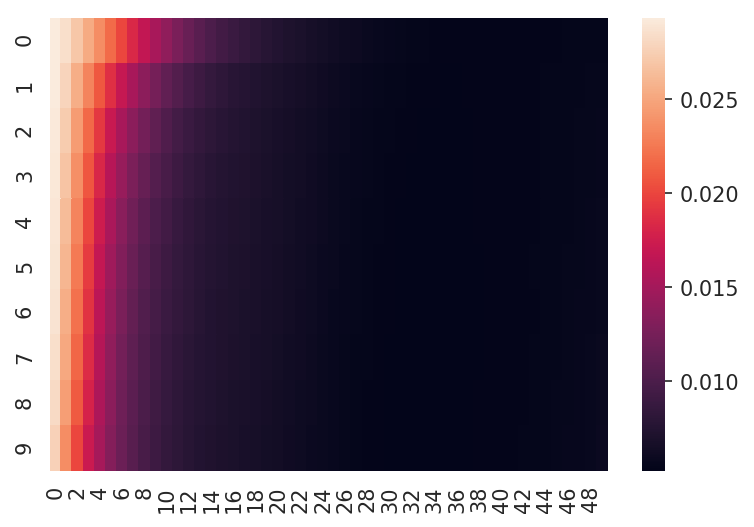

In [243]:
sns.heatmap(new)

In [244]:
coefs = pd.Series(model.coef_, index=X.columns)
nonzero_coefs = coefs[coefs != 0]
nonzero_coefs[nonzero_coefs.abs().argsort()].to_frame().style.background_gradient()

,0
same_as_pres_party_dem_x_Missouri,0.000161861
dem_is_female_x_Indiana,-0.000333265
rep_is_female_x_West Virginia,0.000394752
rep_incumbent_x_Washington,0.000780849
dem_is_female_x_rep_to_tot_oct,-0.000845664
log_med_income_x_Iowa,-0.000920438
rep_incumbent_x_Wisconsin,0.000987455
log_med_income_x_Texas,-0.00104062
dem_incumbent_x_Vermont,-0.00105389
pres_approval_x_Illinois,-0.00150941


/Users/joonyang/code/.virtualenvs/orca/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


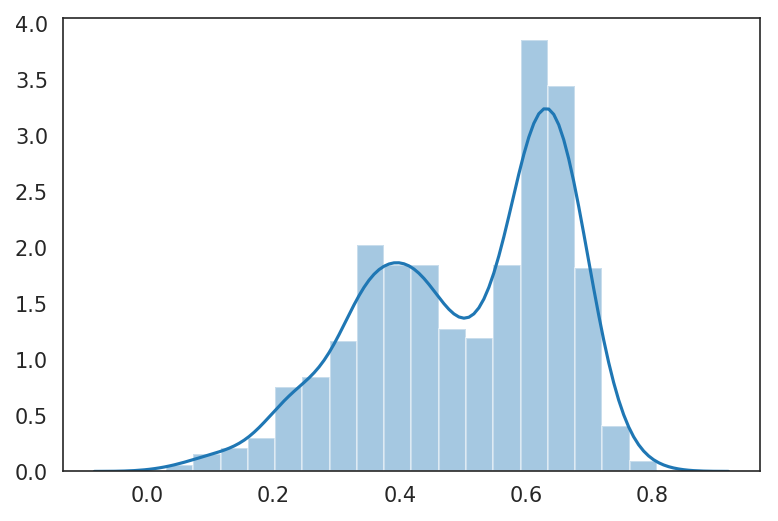

In [245]:
sns.distplot(model.predict(X))

In [246]:
predict = model.predict(X)
train_info['residual_sq'] = (train['rep_score'] - predict) ** 2
train_info['residual'] = (train['rep_score'] - predict)


In [247]:
emp_cov = train_info.pivot_table(index=['state','district'], columns='raceyear', values='residual').T.corr().fillna(0)

In [248]:
# state_cov_matrix = (train_info.groupby(['state_fips', 'district', 'raceyear'])['residual']
#                     .mean().unstack('raceyear').T.corr())
# for i in (range(len(state_cov_matrix))):
#     state_cov_matrix.iloc[i, i] = np.nan
# state_cov_matrix = state_cov_matrix.groupby('state_fips').mean().T.groupby('state_fips').mean()

In [249]:
# state_cov_matrix = state_cov_matrix.fillna(0)

In [250]:
res = train['rep_score'] - predict
res_normal = ((res - res.mean()) / res.std()).values

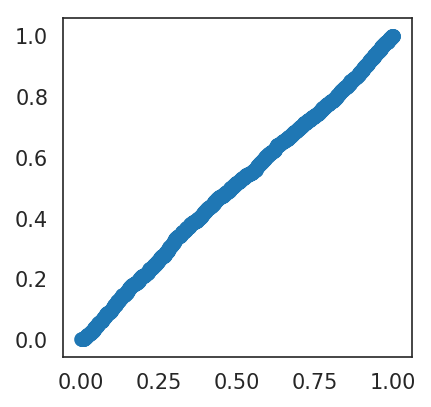

In [251]:
plt.figure(figsize=(3,3))
plt.scatter(ECDF(res_normal)(res_normal), norm.cdf(res_normal))

In [252]:
# Generate mu0 and sigma0 for the test set
mu_0 = model.predict(test_contest.loc[:, 'rep_incumbent':].values)

test_info['sigma2_0'] = test_info['state'].apply(lambda x: sigma2_0[x])
sigma2_0 = test_info['sigma2_0'][test_contest.index]
Sigma_0 = np.diag(sigma2_0.values)

s_d = test_info.loc[test_contest.index][['state', 'district']]            

In [ ]:
# for i in tqdm(range(len(Sigma_0))):
#     for j in range(len(Sigma_0)):
#         if i != j:
#             (st, dis) = s_d.iloc[i]
#             (st2, dis2) = s_d.iloc[j]
#             Sigma_0[i, j] = emp_cov.loc[(st, dis), (st2, dis2)] * Sigma_0[i,i] * Sigma_0[j,j]
from multiprocessing import Pool
from time import time
pool = Pool(6)

def iter_cov(i):
    ret = []
    for j in range(len(Sigma_0)):
        if i != j:
            (st, dis) = s_d.iloc[i]
            (st2, dis2) = s_d.iloc[j]
            ret.append({(i,j): emp_cov.loc[(st, dis), (st2, dis2)] * Sigma_0[i,i] * Sigma_0[j,j]})
    return ret
s = time()
res = list(pool.imap_unordered(iter_cov, range(len(Sigma_0))))
res = np.array(res).flatten()
print(f"{time() - s} Seconds")

In [319]:
for entry in res:
    # once per entry for dict extraction
    for k, v in entry.items():
        (i, j) = k
        Sigma_0[i, j] = v

In [320]:
Sigma_0

array([[ 2.90110105e-03, -5.46758016e-06, -3.56053568e-06, ...,
         7.43727297e-06, -5.77677703e-06, -1.14895962e-05],
       [-5.46758016e-06,  2.70126218e-03,  7.29681739e-06, ...,
        -3.20179809e-06, -3.86983263e-06, -3.76487391e-06],
       [-3.56053568e-06,  7.29681739e-06,  2.70126218e-03, ...,
        -5.31653065e-06,  1.62946452e-06,  9.48950762e-06],
       ...,
       [ 7.43727297e-06, -3.20179809e-06, -5.31653065e-06, ...,
         2.71067920e-03, -5.32538821e-06, -1.26366022e-05],
       [-5.77677703e-06, -3.86983263e-06,  1.62946452e-06, ...,
        -5.32538821e-06,  2.71067920e-03,  1.34169672e-05],
       [-1.14895962e-05, -3.76487391e-06,  9.48950762e-06, ...,
        -1.26366022e-05,  1.34169672e-05,  5.53600183e-03]])

# First update - Generic ballot

In [321]:
generic_ballot = (pd.read_csv('https://projects.fivethirtyeight.com/generic-ballot-data/generic_ballot.csv')
                  .sort_values('date', ascending=False))
generic_ballot = generic_ballot.iloc[0]
z_thresh = 1.644854
sigma2_G = ((generic_ballot['rep_hi']/100 - generic_ballot['rep_lo']/100) / 2 / z_thresh) ** 2

In [322]:
n = len(Sigma_0)
observed = generic_ballot['rep_estimate'] / (generic_ballot['rep_estimate'] + generic_ballot['dem_estimate'])
observed = np.array([observed])
mu1 = np.array([mu_0.mean()])
v1 = np.array([[sigma2_G + Sigma_0.sum() / (n ** 2)]])
v01 = np.diag(Sigma_0)[:, np.newaxis] / n

In [323]:
def normal_conditioning(mu0, mu1, v0, v1, v01, observed):
    new_mu = mu0 + v01 @ np.linalg.inv(v1) @ (observed - mu1)
    new_v = v0 - v01 @ np.linalg.inv(v1) @ v01.T
    return new_mu, new_v

In [324]:
mu_after_gen, sigma_after_gen = normal_conditioning(mu_0, mu1, Sigma_0, v1, v01, observed)

In [325]:
mu_after_gen.mean()

0.4934608420260863

# Second update - Polls

In [326]:
polls = feather.read_dataframe('polls.feather')
sigma2_poll = polls.groupby(['state', 'fivethirtyeight_district'])['rep_score'].std() ** 2
sigma2_poll = sigma2_poll.fillna(sigma2_poll.mean()).reset_index()
sigma2_poll.columns = ['state','fivethirtyeight_district','sigma2_poll']
polls = polls.merge(sigma2_poll)

In [327]:
polls[polls['state'] == 'New York']

,state,id,fivethirtyeight_district,created_at,sampleSize,rep_score,sigma2_poll
424,New York,83306,22,2018-03-12,500.0,0.468085,0.000902
425,New York,83345,22,2017-10-10,561.0,0.488636,0.000902
426,New York,83346,22,2017-11-10,599.0,0.465909,0.000902
427,New York,83353,22,2018-04-27,358.0,0.450000,0.000902
428,New York,86495,22,2018-08-29,499.0,0.488889,0.000902
429,New York,90309,22,2018-10-16,400.0,0.543478,0.000902
430,New York,90776,22,2018-10-24,501.0,0.494505,0.000902
431,New York,83482,19,2018-07-11,545.0,0.461538,0.000596
432,New York,86042,19,2018-08-14,400.0,0.526882,0.000596
433,New York,86508,19,2018-08-30,501.0,0.529412,0.000596


In [328]:
polls = (test_info.reset_index()
         .merge(polls, how='left').dropna()
         .sort_values('created_at').groupby('index')
         .apply(lambda x: x.iloc[-3:])
         .reset_index(drop=True).drop(['sigma2_0','id','created_at'], axis=1))

In [329]:
def update_poll(poll, mu, Sigma):
    m = pd.Series(mu, index=test_contest.index)
    ind = poll['index']
    mu1 = np.array([m[ind]])
    ej = pd.Series(np.zeros(len(test_contest)), 
                  index=test_contest.index)
    ej[ind] = 1
    ej = ej.values
    cov = (Sigma @ ej)[:, np.newaxis]
    v1 = np.array([[1/4/poll['sampleSize'] + poll['sigma2_poll'] + ej.dot(Sigma @ ej)]])
    observation = poll['rep_score']
    
    return normal_conditioning(mu, mu1, Sigma, v1, cov, observation)

In [330]:
mu, Sigma = mu_after_gen.copy(), sigma_after_gen.copy()

In [331]:
mu.mean()

0.4934608420260863

In [332]:
for _, poll in tqdm(polls.iterrows()):
    mu, Sigma = update_poll(poll, mu, Sigma)

In [333]:
mu.mean()

0.4848373512732378

In [334]:
sim = np.random.multivariate_normal(mu, Sigma, size=100000)

In [335]:
rep_uncon = df.query('raceyear==2018')['rep_uncontested'].sum()

In [336]:
(sim > .5).sum(axis=1).mean()

210.64738

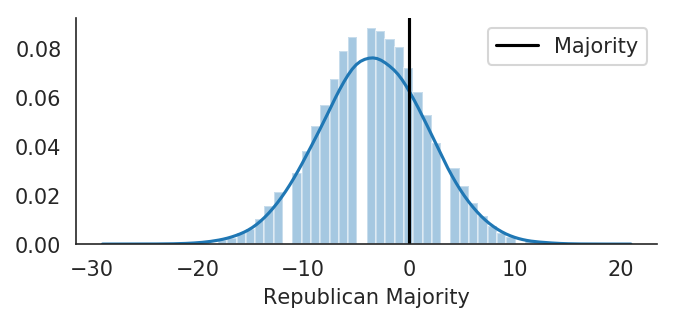

In [337]:
plt.figure(figsize=(5,2))
sns.distplot((sim > .5).sum(axis=1) + rep_uncon - 217, bins=50, kde_kws={'bw':1})
plt.axvline(0, color='k', label='Majority')
plt.xlabel('Republican Majority')
plt.legend()
# plt.xlim((195,235))
sns.despine()
plt.savefig('report/rep_seats.pdf')

In [270]:
1-((sim > .5).sum(axis=1) + 3 > 217.5).mean()

0.77151

In [271]:
(sim > .5).sum(axis=1).std()

5.1273310043725475

In [ ]:
test_info['mu'] = mu
test_info['sigma'] = np.diag(Sigma) ** .5

In [ ]:
test_info['edge'] = (test_info['mu'] - .5) / test_info['sigma']

In [ ]:
maps = gpd.read_file('data/kx-us-116th-congressional-districts-SHP (1)/us-116th-congressional-districts.shp')

In [ ]:
def wrapper(func, x):
    try:
        return func(x)
    except:
        return None

In [ ]:
maps['state_fips'] = maps['GEOID'].apply(lambda x : int(x[:2]))
maps['district'] = maps['GEOID'].apply(lambda x : wrapper(int, x[2:]))

In [ ]:
maps = maps[['state_fips', 'district', 'geometry']].copy()

In [ ]:
uncon = df.loc[test_uncontest.index, ['state_fips', 'district', 'rep_uncontested']].copy()

In [ ]:
uncon['mu'] = uncon['rep_uncontested'].astype(float)

In [ ]:
uncon['sigma'] = 0
uncon['edge'] = (uncon['mu'] - .5) * 40

In [ ]:
preds = pd.concat([test_info, uncon.drop('rep_uncontested', axis=1)], sort=False)

In [ ]:
final_map = maps.merge(preds, how='right', on=['state_fips', 'district'])

In [ ]:
f, ax = plt.subplots(1, figsize=(7, 5))
final_map.query('state not in ["Alaska", "Hawaii"]')[['geometry', 'mu']]\
.plot('mu', cmap='coolwarm', vmin=0.3, vmax=.7, 
      linewidth=0, figsize=(5,5), ax=ax)

ax.set_aspect(aspect=1.3)
ax.axis('off')

# plt.savefig('report/projected_map.eps')

# Produce a table of predictions

In [ ]:
preds['state'] = preds['state_fips'].apply(lambda x: us.states.lookup(str(x).zfill(2)).name)

In [ ]:
from scipy.stats import norm

In [ ]:
def compute_prob_republican(x):
    if x['sigma'] == 0:
        return x['mu']
    else:
        return 1 - norm.cdf((.5 - x['mu']) / x['sigma'])

In [ ]:
preds['republican_win_prob'] = preds.apply(compute_prob_republican, axis=1)

In [ ]:
preds = preds.merge(df.query('raceyear == 2018')[['state_fips', 'district', 'rep_lastname', 'dem_lastname']])

In [ ]:
preds['projected_winning_candidate'] = preds.apply(lambda x : x['rep_lastname']  + ' (R)'
                                                   if x['republican_win_prob'] > .5 
                                                   else x['dem_lastname'] + ' (D)', axis=1)


In [ ]:
preds['winner_prob'] = np.maximum(preds['republican_win_prob'], 1-preds['republican_win_prob'])

In [ ]:
preds['cong_district'] = preds['state'].astype(str) + '-' + preds['district'].astype(str).str.zfill(2)

In [ ]:
winners = preds.sort_values(['state', 'district'])[['cong_district', 'projected_winning_candidate', 'winner_prob']].copy()
winners.columns = ['District', 'Projected Winner', 'Probability']

In [ ]:
with open('report/projected_results.tex', 'w') as f:
    f.write(winners.to_latex(index=False, longtable=True))

In [ ]:
winners.to_csv('report/projections.csv', index=False)